In [62]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR,LinearSVR, OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor


from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [63]:
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+1)
    if kernel == 'linear':
        return sp*(2*p-1)
    return sp*(2*p+2)

def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In [64]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
df = pd.read_csv(uploaded)

In [65]:
# from google.colab import files
df[['day','month']] = OrdinalEncoder().fit_transform(df[['day','month']])
X = df.drop(columns=['area'])
y = df['area']
features=X.columns
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.036246,0.417296,0.084074,0.157756,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344,12.846934
kurtosis,-1.172331,1.420553,-1.719350,-1.101004,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964,194.140721


In [66]:
outliers = LocalOutlierFactor(420).fit_predict(X)
target_out = LocalOutlierFactor(420).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X,y=X[outliers],y[outliers]
X.shape

(449, 12)

In [67]:
X = StandardScaler().fit_transform(X)

In [68]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = features
vif

,VIF Factor,features
0,1.434441,X
1,1.452263,Y
2,1.479443,month
3,1.055148,day
4,1.678582,FFMC
5,2.782684,DMC
6,2.886508,DC
7,1.576343,ISI
8,2.932642,temp
9,2.095577,RH


One recommendation is that if VIF  ( 1/(1-r2_score) with given feature and all the other ) is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.[https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html]



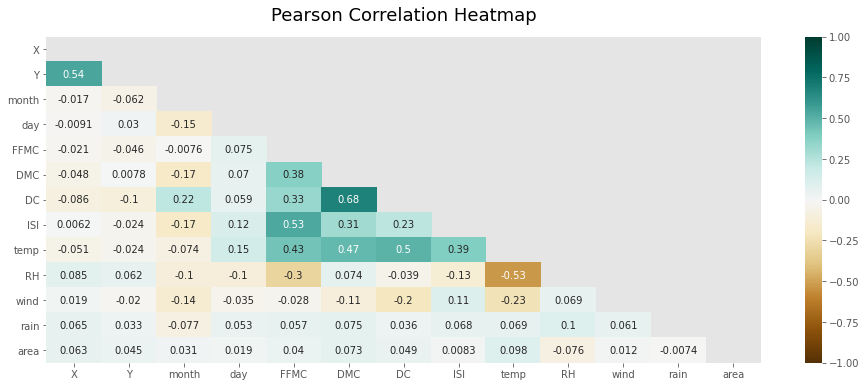

In [70]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Pearson Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Padas corr method:{default:‘pearson’, ‘kendall’, ‘spearman’}

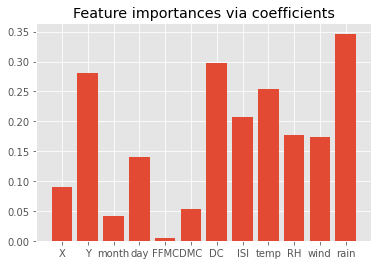

In [234]:
model = LinearRegression()
model.fit(X,y)
feature_importances = np.abs(model.coef_).reshape(12,)

feature_names = df.columns.to_numpy()
plt.bar(height=feature_importances, x=feature_names[:-1])
plt.title("Feature importances via coefficients")
plt.show()

In [174]:
# score_func=mutual_info_regression
# # score_func=f_regression

# cv=10
# grid = dict()
# grid['sel__k'] = [i for i in range(1,13)]

# models=[(LinearSVR(),'SVR'),(LinearRegression(),'LinearRegression')]

# for model,name in models:
#   fs = SelectKBest(score_func=score_func)
#   pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

#   gcv = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

#   results = gcv.fit(X, y)
#   means = results.cv_results_['mean_test_score']
#   params = results.cv_results_['params']
#   params =[d['sel__k'] for d in params]
#   for i in range(len(means)):
#       means[i]=-means[i]
#   plt.plot(params,means,label='MSE vs. k with '+name)
#   plt.legend()
#   plt.xlabel('number of features')
#   plt.ylabel('MSE')
# plt.show()

In [251]:
k=1
X=SelectKBest(score_func=score_func,k=k).fit_transform(X,y)

In [252]:
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
acc_metric = 'neg_mean_squared_error'
# acc_metric = 'neg_mean_absolute_error'
X.shape

(449, 1)

Best Hyperparameters::
{'C': 0.001, 'kernel': 'linear'}
Best Hyperparameters::
{'C': 0.47421052631578947, 'kernel': 'linear'}
SOC:  402
MSE:  16.685461767316905 STD:  17.442375224850895


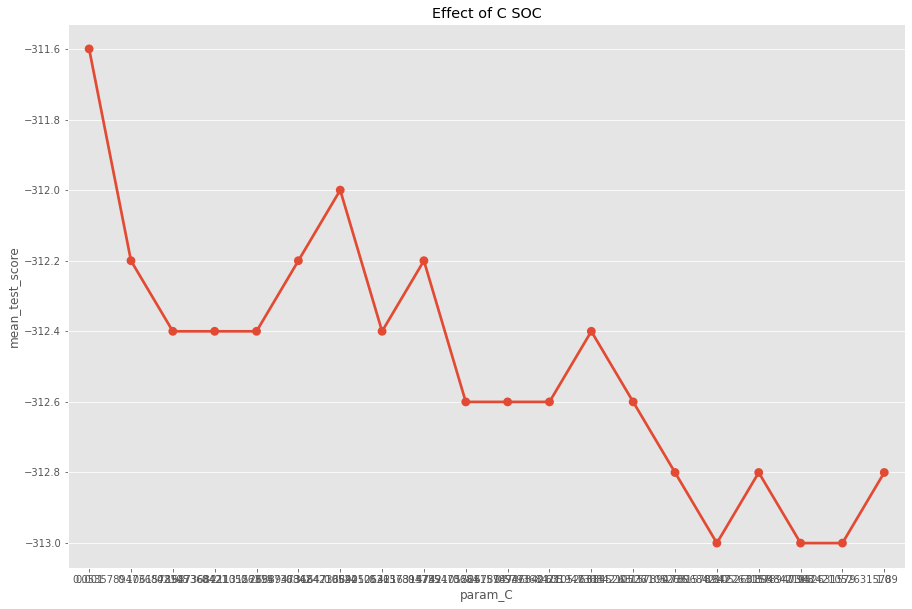

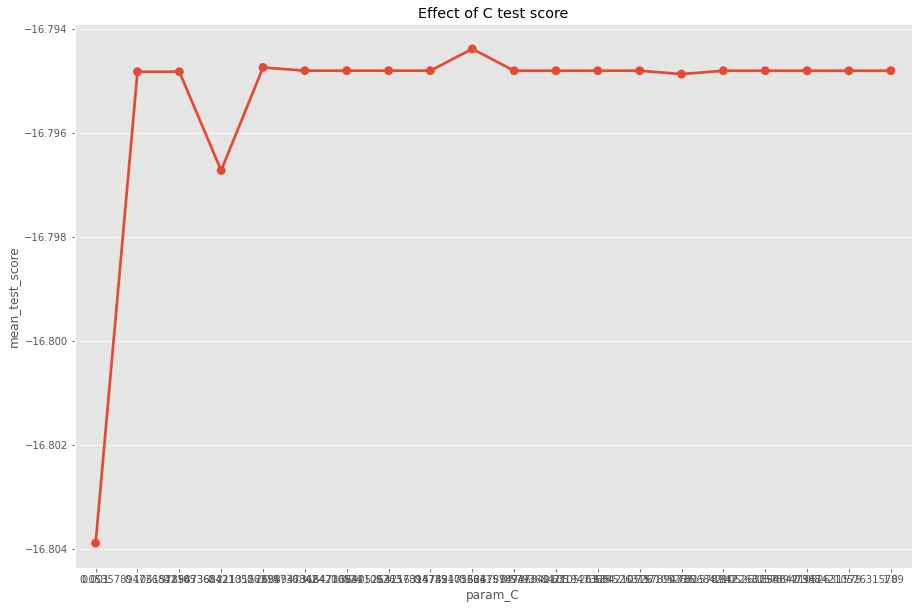

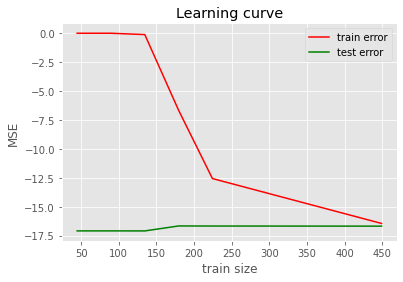

In [253]:


params = {'C':np.linspace(0.001,1,20),
          'kernel':['linear']}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C SOC")

gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")


svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k-1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters: 
{'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Best Hyperparameters: 
{'C': 10000.0, 'gamma': 0.1, 'kernel': 'rbf'}
# SV 389
SOC:  1556
MSE:  15.55557188586105 STD:  16.872103219007247


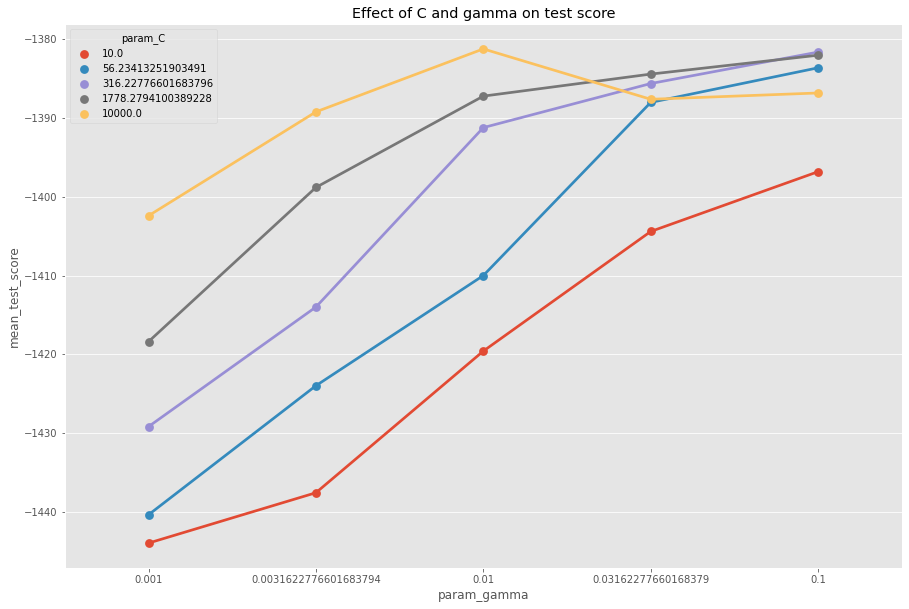

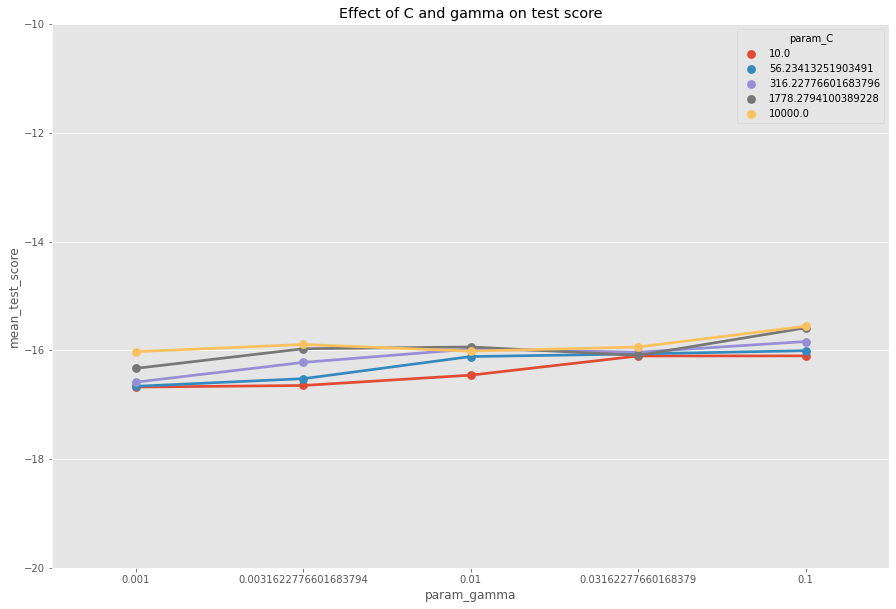

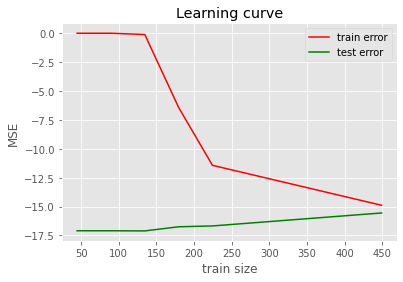

In [254]:
params = {'C':np.logspace(1,4,10),
          'gamma':np.logspace(-3,-1,10),
          'kernel':['rbf']}
params = {'C':np.logspace(1,4,5),
          'gamma':np.logspace(-3,-1,5),
          'kernel':['rbf']}
gcv = GridSearchCV(SVR(),params,cv=cv,scoring=soc_metric)
gcv.fit(X,y)
print('Best Hyperparameters: \n{}'.format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
# ax.set_ylim([-20,-10])
sns.pointplot(data=results[['mean_test_score',
                          'param_C',
                          'param_gamma']],
            y='mean_test_score',x='param_gamma',
            hue='param_C',ax=ax)
ax.set(title='Effect of C and gamma on test score')


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print('Best Hyperparameters: \n{}'.format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-20,-10])
sns.pointplot(data=results[['mean_test_score',
                          'param_C',
                          'param_gamma']],
            y='mean_test_score',x='param_gamma',
            hue='param_C',ax=ax)
ax.set(title='Effect of C and gamma on test score')
svr=gcv.best_estimator_
print('# SV',len(svr.support_vectors_))
print('SOC: ',len(svr.support_vectors_)*(3*k+1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print('MSE: ',mse,'STD: ',std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title('Learning curve')
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters: 
{'C': 100, 'gamma': 1668.100537200059, 'kernel': 'sigmoid'}
Best Hyperparameters: 
{'C': 0.05, 'gamma': 7.742636826811269, 'kernel': 'sigmoid'}
SOC:  1728
MSE:  15.376601361214856 STD:  15.64269220056343


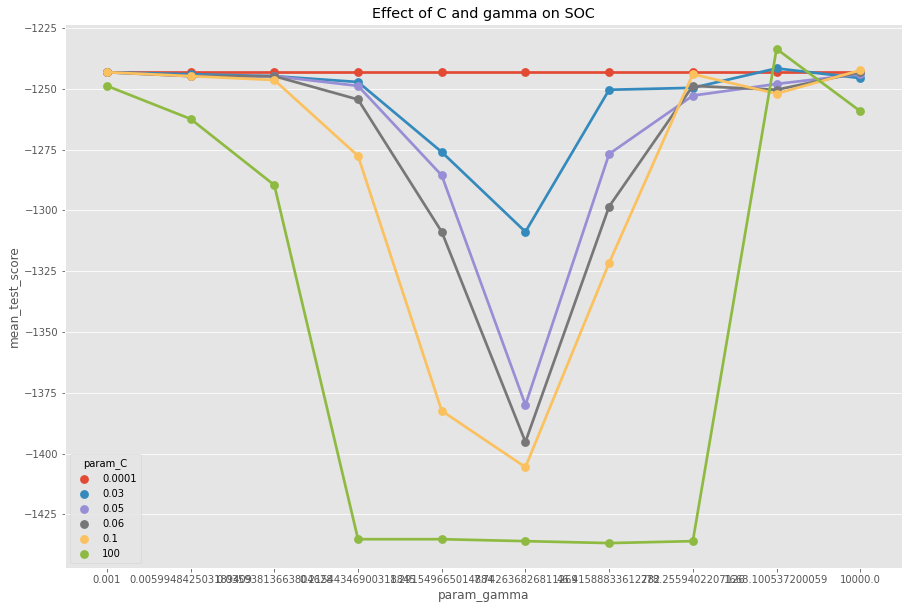

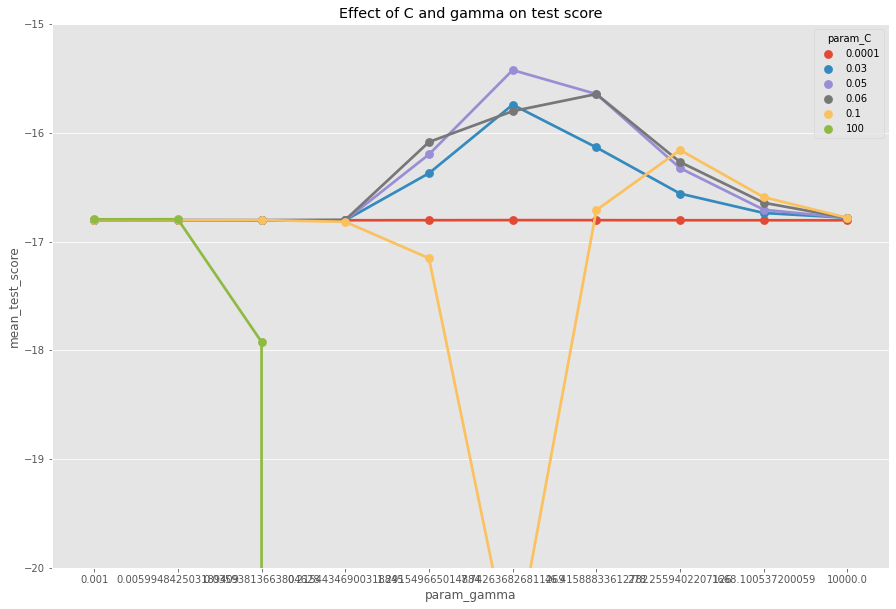

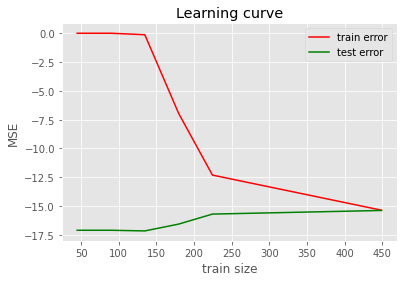

In [255]:
params = {'C':[0.05,0.06,0.03,0.1,0.0001,100],
          'gamma':np.logspace(-3,4,10),
          'kernel':['sigmoid',]}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters: \n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
# ax.set_ylim([-20,-15])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on SOC")

gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters: \n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-20,-15])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")

svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Best Hyperparameters::
{'C': 2, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
SOC:  1544
MSE:  16.462408415409122 STD:  17.327551415656256


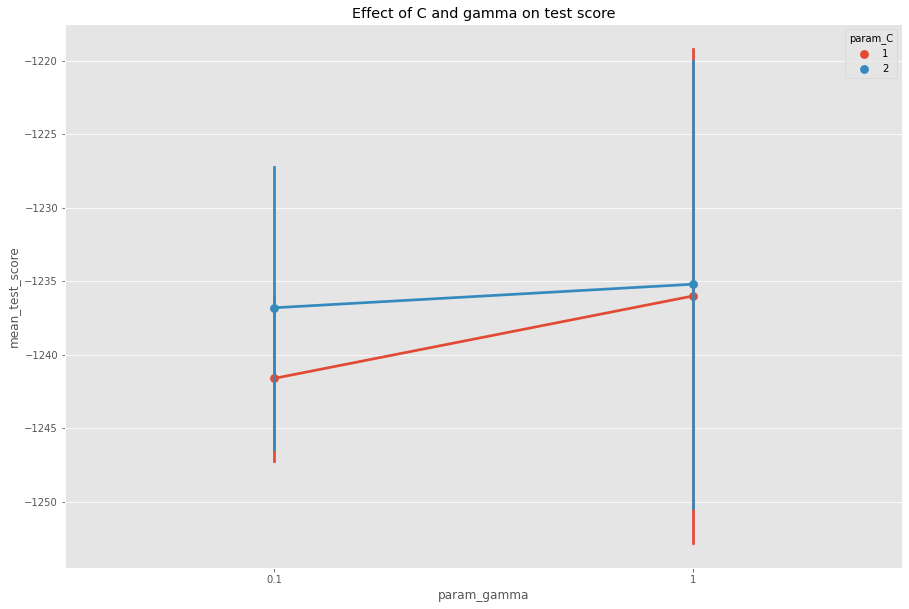

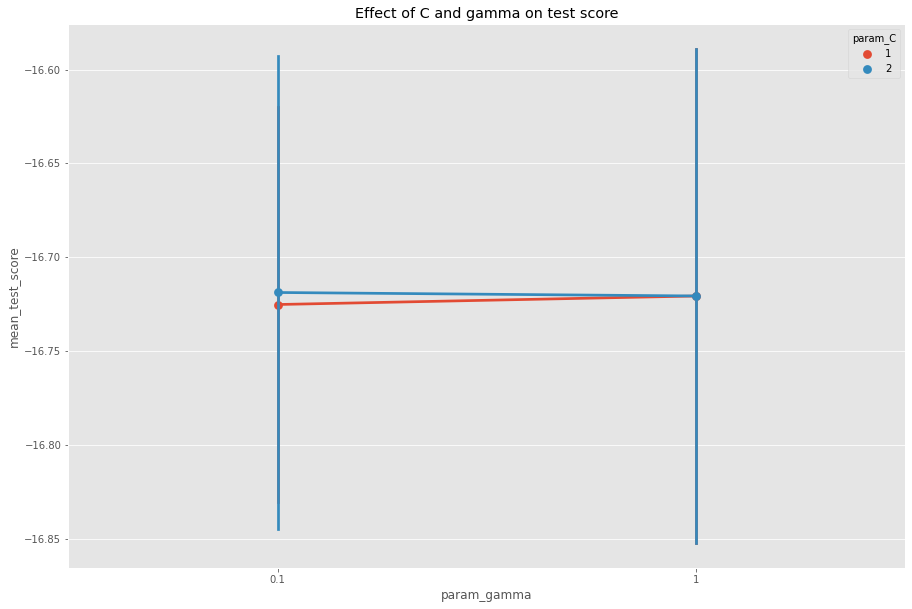

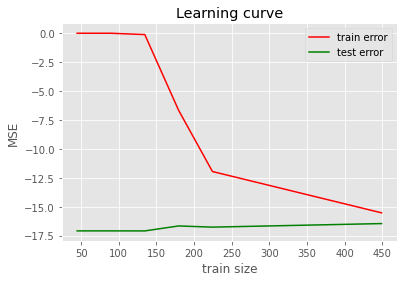

In [256]:
params = {'C':[1,2],
          'gamma':[0.1,1],
          'degree':[2,3],
          'kernel':['poly'],
         }

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [257]:
soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
print('Best Model:')
print(model_selected, 'kernel: ',model_selected.kernel)
print('SOC ',soc)
print('MSE ',minRMSE)

Best Model:
SVR(C=0.05, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=7.742636826811269, kernel='sigmoid', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) kernel:  sigmoid
SOC  1728
MSE  15.376601361214856


In [258]:
import pickle
!git config --global user.email "nazirzhumakhan@gmail.com"
!git config --global user.name "zhumakhan"

!git clone https://github.com/zhumakhan/IML.git
filename='./forest+svr.model'

with open(filename, 'wb') as file:
    pickle.dump(model_selected,file)

!mv ./forest+svr.model ./IML/forest+svr.model
!cd IML && git add . && git commit -m'svr model update' && git push --force
!rm -rf ./IML

# some time later...
# load the model from disk
# loaded_model = pickle.load(open('./IML/forest+svr.model', 'rb'))
# print(loaded_model)
# result = loaded_model.score(X_test, Y_test)
# print(result)

Cloning into 'IML'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 51 (delta 29), reused 51 (delta 29), pack-reused 0
Unpacking objects: 100% (51/51), done.
[master a1aa643] svr model update
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite forest+svr.model (98%)
fatal: could not read Username for 'https://github.com': No such device or address


Text(0, 0.5, 'MSE')

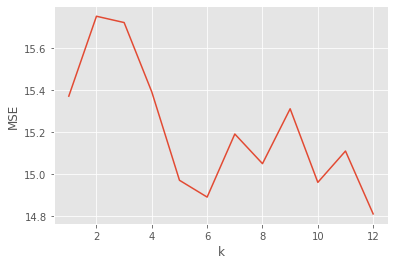

In [183]:
mses = np.array([15.37,15.75,15.72,15.39,14.97,14.89,15.19,15.049,15.31,14.96,15.109,14.81])
plt.plot([k for k in range(1,13)],mses)
plt.xlabel('k')
plt.ylabel('MSE')